## Import and Setup


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from torch.utils.data import DataLoader, random_split, Subset, ConcatDataset
from torchvision import datasets, transforms, models
from sklearn.model_selection import GridSearchCV
from torchvision.models import AlexNet_Weights
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.multiclass import OutputCodeClassifier
from google.colab import drive

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

drive.mount('/content/drive')
train_dir = '/content/drive/My Drive/CV_Project/datasets/train'
test_dir  = '/content/drive/My Drive/CV_Project/datasets/test'


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Data Augmentation
We perform data augmentation as before and
* since AlexNet was trained in ImageNet, where images are RGB (3 channels) and the typical resolution is 224×224, we normalize our images
* we add the standard normalization of ImageNet (`mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]`), necessary for the pre-trained network to function well, as said in [PyTorch](https://pytorch.org/vision/stable/models/generated/torchvision.models.alexnet.html#torchvision.models.AlexNet_Weights)


In [ ]:
train_transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    transforms.RandomResizedCrop(size=(224, 224), scale=(0.8, 1.0)),
    transforms.RandomRotation(degrees=10),
    transforms.RandomHorizontalFlip(p=0.75),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

val_test_transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    transforms.Resize((256, 256)),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

## Dataset Building and Splitting
The splitting is the same as before

In [ ]:
train_val_dataset = datasets.ImageFolder(root=train_dir)

dataset_size = len(train_val_dataset)
train_len = int(0.85 * dataset_size)
val_len = dataset_size - train_len

train_subset, val_subset = random_split(train_val_dataset, [train_len, val_len])

train_original = Subset(train_val_dataset, train_subset.indices)
train_original.dataset.transform = val_test_transform

train_augmented = Subset(train_val_dataset, train_subset.indices)
train_augmented.dataset.transform = train_transform

train_dataset = ConcatDataset([train_original, train_augmented])

val_dataset = Subset(train_val_dataset, val_subset.indices)
val_dataset.dataset.transform = val_test_transform

test_dataset = datasets.ImageFolder(
    root=test_dir,
    transform=val_test_transform
)

## Dataloaders

In [ ]:
batch_size = 32

train_loader = DataLoader(train_dataset,
                          batch_size=batch_size,
                          shuffle=True,
                          num_workers=2,
                          pin_memory=True)

val_loader = DataLoader(val_dataset,
                        batch_size=batch_size,
                        shuffle=False,
                        num_workers=2,
                        pin_memory=True)

test_loader = DataLoader(test_dataset,
                         batch_size=batch_size,
                         shuffle=False,
                         num_workers=2,
                         pin_memory=True)

num_classes = len(train_original.dataset.classes)
class_names = train_original.dataset.classes

## Function for plotting confusion matrix

In [ ]:
def plot_confusion_matrix(cm, class_names, title="Confusion Matrix"):

    cm_normalized = cm / cm.sum(axis=1, keepdims=True)
    cm_normalized = np.nan_to_num(cm_normalized)

    annot = np.empty_like(cm, dtype=object)
    nrows, ncols = cm.shape
    for i in range(nrows):
        for j in range(ncols):
            count = cm[i, j]
            pct = cm_normalized[i, j] * 100
            annot[i, j] = f"{count}\n({pct:.1f})"

    plt.figure(figsize=(10, 10))
    sns.heatmap(cm_normalized,
                annot=annot,
                fmt="",
                cmap='Blues',
                xticklabels=class_names,
                yticklabels=class_names,
                vmin=0.0, vmax=1.0)
    plt.title(title)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.tight_layout()
    plt.show()

## ALexNet Tuning (first implementation)
The aim of this function is to:
* load the pre-trained Alex-Net network using [torchvision.models.alexnet](https://github.com/pytorch/vision/blob/main/torchvision/models/alexnet.py)
* freeze all the layer but the last
* fine-tuning


==== Using AlexNet fine-tuning ====

[Finetune] Epoch [1/30] Train Loss: 1.6269, Train Acc: 54.47% || Val Loss: 1.0246, Val Acc: 75.11%
[Finetune] Epoch [2/30] Train Loss: 0.7511, Train Acc: 82.39% || Val Loss: 0.7226, Val Acc: 80.00%
[Finetune] Epoch [3/30] Train Loss: 0.5367, Train Acc: 87.49% || Val Loss: 0.6169, Val Acc: 82.67%
[Finetune] Epoch [4/30] Train Loss: 0.4286, Train Acc: 89.76% || Val Loss: 0.5730, Val Acc: 80.44%
[Finetune] Epoch [5/30] Train Loss: 0.3639, Train Acc: 91.73% || Val Loss: 0.5269, Val Acc: 83.56%
[Finetune] Epoch [6/30] Train Loss: 0.3207, Train Acc: 92.47% || Val Loss: 0.5126, Val Acc: 83.56%
[Finetune] Epoch [7/30] Train Loss: 0.2807, Train Acc: 93.65% || Val Loss: 0.4975, Val Acc: 84.00%
[Finetune] Epoch [8/30] Train Loss: 0.2598, Train Acc: 94.08% || Val Loss: 0.4858, Val Acc: 83.11%
[Finetune] Epoch [9/30] Train Loss: 0.2269, Train Acc: 95.73% || Val Loss: 0.4805, Val Acc: 83.56%
[Finetune] Epoch [10/30] Train Loss: 0.2097, Train Acc: 95.33% || Val L

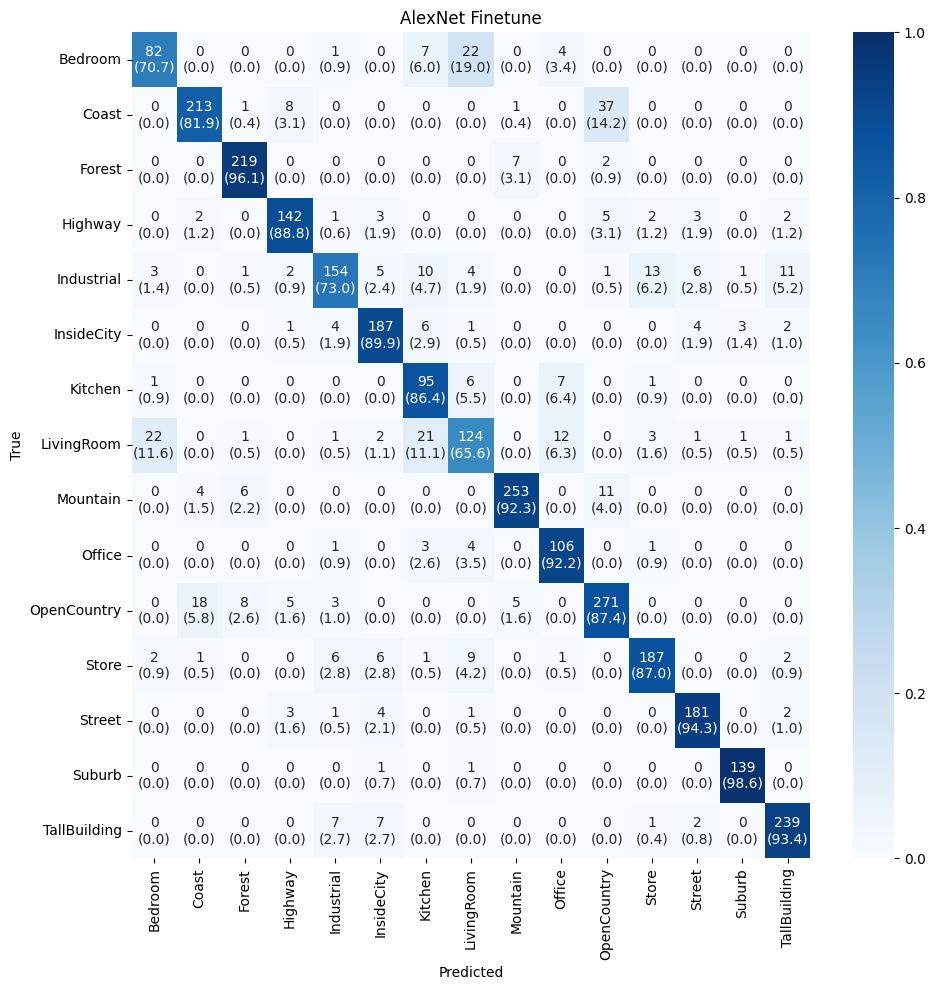

In [ ]:
def train_alexnet_finetune(num_epochs=30, patience=5, lr=1e-4):
    weights = AlexNet_Weights.DEFAULT
    model = models.alexnet(weights=weights)

    for param in model.parameters():
        param.requires_grad = False

    model.classifier[6] = nn.Linear(4096, num_classes)
    for param in model.classifier[6].parameters():
        param.requires_grad = True

    model = model.to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.classifier[6].parameters(), lr=lr)

    best_val_loss = np.inf
    epochs_no_improve = 0

    for epoch in range(num_epochs):
        model.train()
        train_loss_sum = 0.0
        train_correct = 0
        train_total = 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_loss_sum += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            train_correct += (predicted == labels).sum().item()
            train_total += labels.size(0)

        epoch_train_loss = train_loss_sum / len(train_dataset)
        epoch_train_acc = 100.0 * train_correct / train_total

        model.eval()
        val_loss_sum = 0.0
        val_correct = 0
        val_total = 0

        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)

                val_loss_sum += loss.item() * images.size(0)
                _, predicted = torch.max(outputs, 1)
                val_correct += (predicted == labels).sum().item()
                val_total += labels.size(0)

        epoch_val_loss = val_loss_sum / len(val_dataset)
        epoch_val_acc = 100.0 * val_correct / val_total

        print(f"[Finetune] Epoch [{epoch+1}/{num_epochs}] "
              f"Train Loss: {epoch_train_loss:.4f}, Train Acc: {epoch_train_acc:.2f}% || "
              f"Val Loss: {epoch_val_loss:.4f}, Val Acc: {epoch_val_acc:.2f}%")

        if epoch_val_loss < best_val_loss:
            best_val_loss = epoch_val_loss
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1
            if epochs_no_improve >= patience:
                print()
                print("Early stopping triggered.")
                break

    model.eval()
    test_correct = 0
    test_total = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            test_correct += (predicted == labels).sum().item()
            test_total   += labels.size(0)

            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(predicted.cpu().numpy())

    test_acc = 100.0 * test_correct / test_total
    print()
    print(f"[Finetune] Test Accuracy: {test_acc:.2f}%")
    print()

    cm = confusion_matrix(all_labels, all_preds)
    plot_confusion_matrix(cm, class_names, title="AlexNet Finetune")

    return model

print("\n==== Using AlexNet fine-tuning ====\n")
finetuned_model = train_alexnet_finetune(num_epochs=30, patience=5, lr=1e-4)


## Feature Extraction (second implementation)
* pass the images through AlexNet, stopping at the second to last fully connected layer (4096 dimension) instead of getting final predictions
* exports features that describe each image in a detailed but abstract way
* collects the features and labels into two separate arrays and returns it

In [ ]:
def extract_features_alexnet(dataloader, model):
    model.eval()
    features_list = []
    labels_list   = []

    with torch.no_grad():
        for images, labels in dataloader:
            images = images.to(device)

            x = model.features(images)
            x = model.avgpool(x)
            x = torch.flatten(x, 1)
            x = model.classifier[0](x)
            x = model.classifier[1](x)
            x = model.classifier[2](x)
            x = model.classifier[3](x)
            x = model.classifier[4](x)
            x = model.classifier[5](x)

            x = x.cpu().numpy()
            features_list.append(x)
            labels_list.append(labels.numpy())

    features_arr = np.concatenate(features_list, axis=0)
    labels_arr = np.concatenate(labels_list, axis=0)
    return features_arr, labels_arr


## Linear SVM and NON Linear variants
The aim of this function is:
* loading the AlexNet model with pretrained weights and freezes all parameters to ensure no updates during feature extraction.
* extracting feature with `extract_features_alexnet` function
* normalize feature (zero mean and unit standard deviation)
* perform grid search to optimize hyperparameters of an SVM classifier (e.g., kernel and other parameters) using the extracted features
* use the extracted and normalized 4096-dim features from the train/val/test sets for training and evaluating the SVM classifier
* output the best classifier and the best parameters (the second to be used later in ECOC)


In [ ]:
def train_alexnet_svm(param_grid, kernel):

    weights = models.AlexNet_Weights.DEFAULT
    model = models.alexnet(weights=weights).to(device)

    for param in model.parameters():
        param.requires_grad = False

    print("-------------------------------------")
    print("Extracting train features...")
    train_features, train_labels = extract_features_alexnet(train_loader, model)
    print("Extracting validation features...")
    val_features, val_labels     = extract_features_alexnet(val_loader, model)
    print("Extracting test features...")
    test_features, test_labels   = extract_features_alexnet(test_loader, model)
    print('-------------------------------------')

    scaler = StandardScaler()
    train_features = scaler.fit_transform(train_features)
    val_features   = scaler.transform(val_features)
    test_features  = scaler.transform(test_features)

    print(f"Tuning hyperparameters for SVM ({kernel} kernel)...")
    base_svc = SVC(kernel=kernel)

    grid_search = GridSearchCV(
        estimator=base_svc,
        param_grid=param_grid,
        cv=3,
        verbose=2,
        n_jobs=-1
    )

    print("Fitting grid search on training set...")
    grid_search.fit(train_features, train_labels)
    print()
    print(f"\nBest params found by grid search: {grid_search.best_params_}\n")
    print()

    best_svc = grid_search.best_estimator_
    best_params = grid_search.best_params_

    test_pred = best_svc.predict(test_features)
    test_acc = 100.0 * np.sum(test_pred == test_labels) / len(test_labels)
    print(f"Best SVM Test Accuracy: {test_acc:.2f}%\n")
    print()

    cm = confusion_matrix(test_labels, test_pred)
    plot_confusion_matrix(cm, class_names, title=f"AlexNet Features + SVM ({kernel})")
    print()

    print("--------------------------------------------------------------------------")
    return best_svc, best_params

## Running second implementation
At this point we can run the second implementation using different kernels and parameters for grid search. The used kernels are:
* linear
* radial basis function
* polynomial
* sigmoid


==== Using AlexNet as Feature Extractor + SVM (linear) ====

-------------------------------------
Extracting train features...
Extracting validation features...
Extracting test features...
-------------------------------------
Tuning hyperparameters for SVM (linear kernel)...
Fitting grid search on training set...
Fitting 3 folds for each of 5 candidates, totalling 15 fits


Best params found by grid search: {'C': 0.01}


Best SVM Test Accuracy: 86.33%




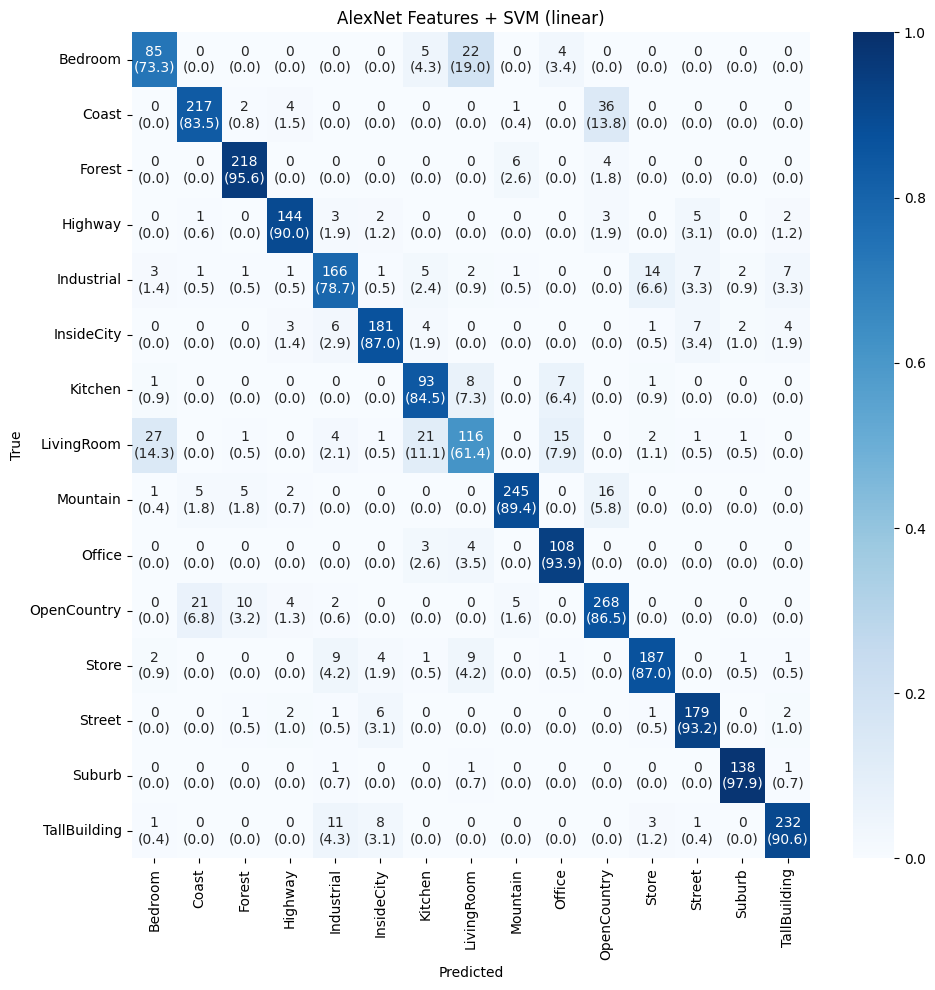


--------------------------------------------------------------------------

==== Using AlexNet as Feature Extractor + Non-Linear SVM (rbf) ====

-------------------------------------
Extracting train features...
Extracting validation features...
Extracting test features...
-------------------------------------
Tuning hyperparameters for SVM (rbf kernel)...
Fitting grid search on training set...
Fitting 3 folds for each of 36 candidates, totalling 108 fits


Best params found by grid search: {'C': 10, 'gamma': 0.0001}


Best SVM Test Accuracy: 83.99%




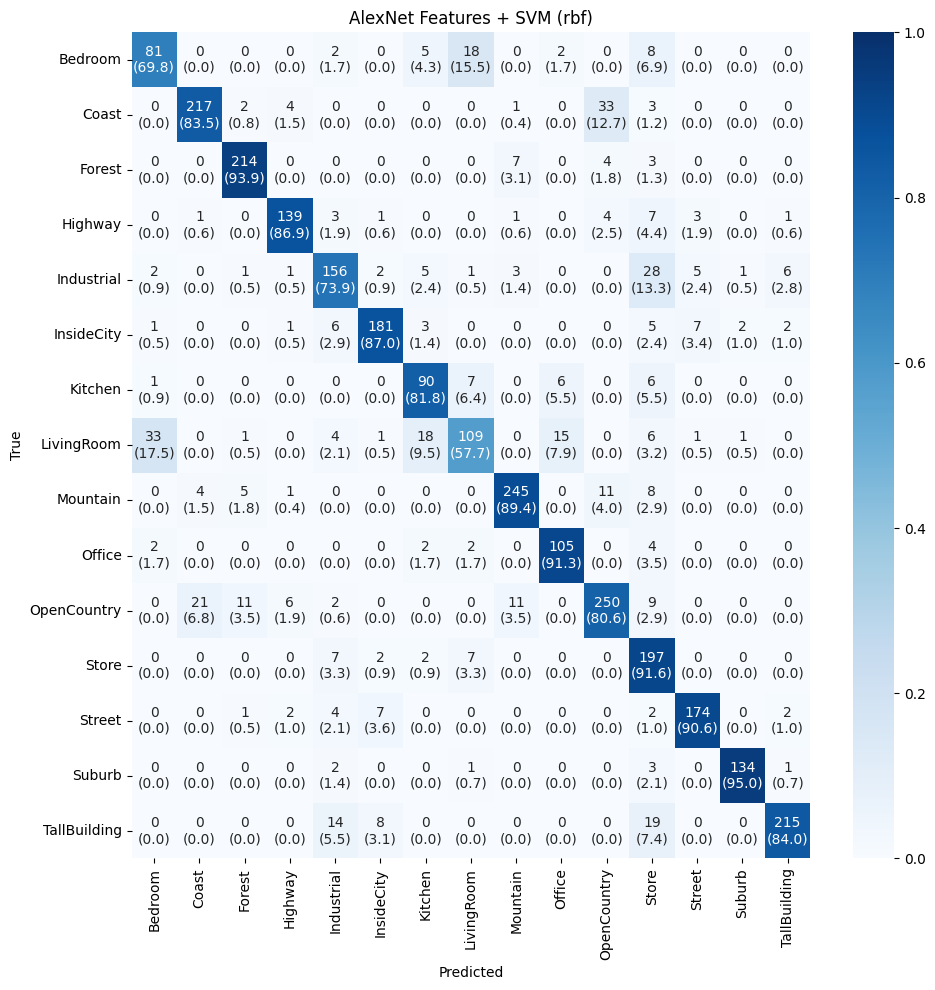


--------------------------------------------------------------------------

==== Using AlexNet as Feature Extractor + Non-Linear SVM (poly) ====

-------------------------------------
Extracting train features...
Extracting validation features...
Extracting test features...
-------------------------------------
Tuning hyperparameters for SVM (poly kernel)...
Fitting grid search on training set...
Fitting 3 folds for each of 36 candidates, totalling 108 fits


Best params found by grid search: {'C': 0.01, 'gamma': 0.01}


Best SVM Test Accuracy: 67.44%




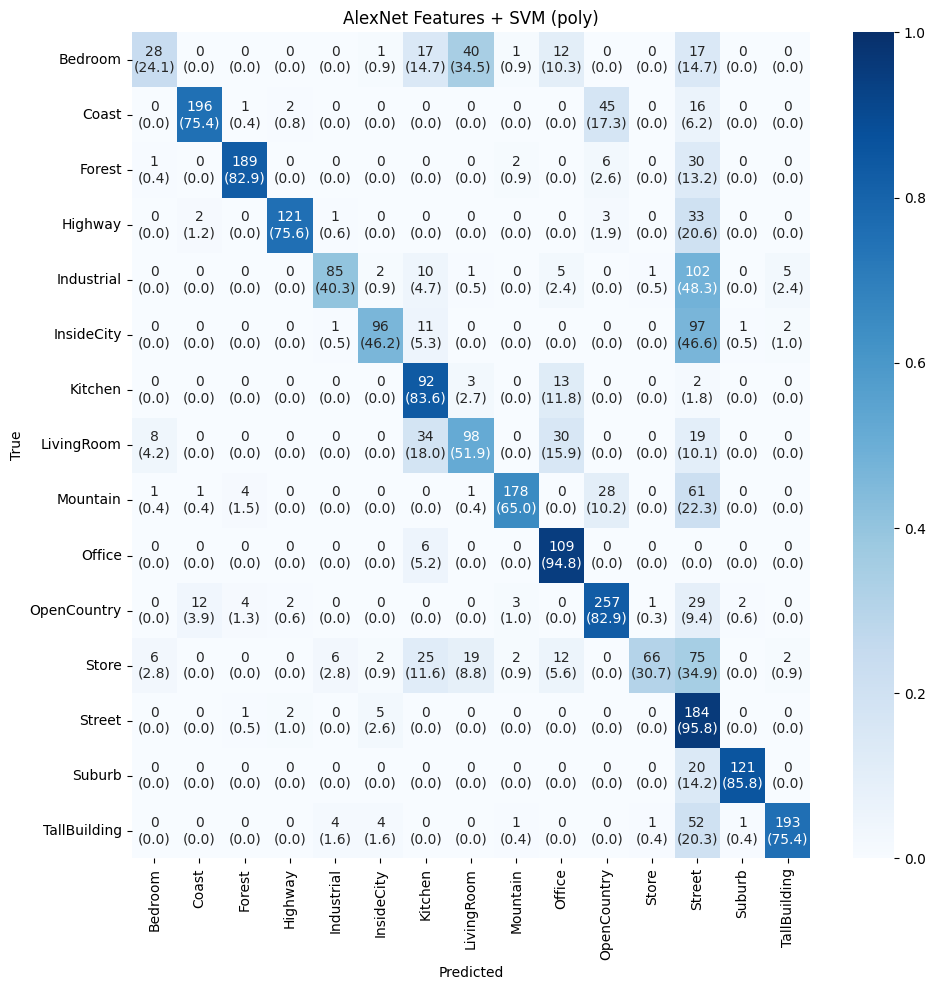


--------------------------------------------------------------------------

==== Using AlexNet as Feature Extractor + Non-Linear SVM (sigmoid) ====

-------------------------------------
Extracting train features...
Extracting validation features...
Extracting test features...
-------------------------------------
Tuning hyperparameters for SVM (sigmoid kernel)...
Fitting grid search on training set...
Fitting 3 folds for each of 36 candidates, totalling 108 fits


Best params found by grid search: {'C': 10, 'gamma': 0.0001}


Best SVM Test Accuracy: 86.80%




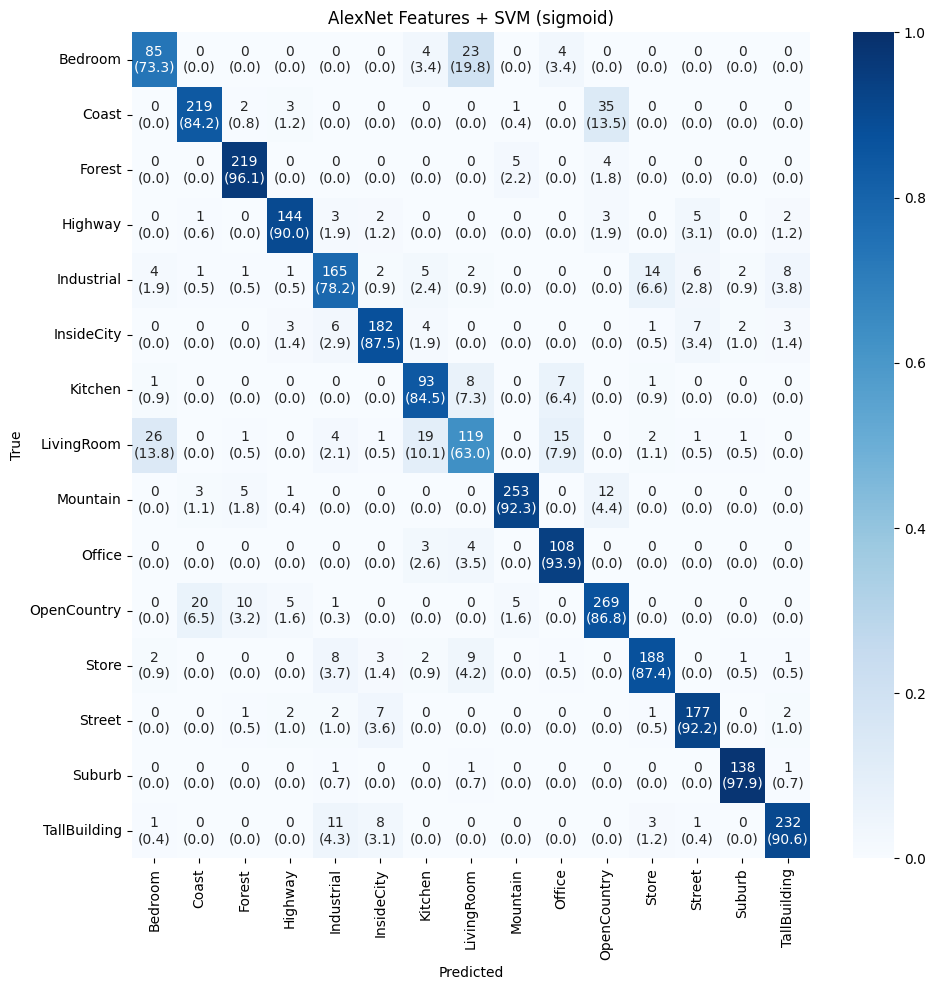


--------------------------------------------------------------------------


In [ ]:
param_grid_linear = {
    'C': [0.01, 0.1, 1, 10, 100]
}

param_grid_non_linear = {
    'C': [0.01, 0.1, 1, 10, 100],
    'gamma': [1e-4, 1e-3, 1e-2, 0.1, 1, 10]
}

print("\n==== Using AlexNet as Feature Extractor + SVM (linear) ====\n")
svm_model_linear, best_params_linear = train_alexnet_svm(param_grid_linear, 'linear')

print("\n==== Using AlexNet as Feature Extractor + Non-Linear SVM (rbf) ====\n")
svm_model_rbf, best_params_rbf = train_alexnet_svm(param_grid_non_linear, 'rbf')

print("\n==== Using AlexNet as Feature Extractor + Non-Linear SVM (poly) ====\n")
svm_model_poly, best_params_poly = train_alexnet_svm(param_grid_non_linear, 'poly')

print("\n==== Using AlexNet as Feature Extractor + Non-Linear SVM (sigmoid) ====\n")
svm_model_sigmoid, best_params_sigmoid = train_alexnet_svm(param_grid_non_linear, 'sigmoid')

## Error Correcting Ouptut Code
Now we train a multiclass SVM using the Error-Correcting Output Code approach on top of AlexNet-extracted features, using the best parameters found before.


The aim of this function is:
* loads the AlexNet model with pretrained weights and freezes all parameters to ensure no updates during feature extraction.
* extract feature with `extract_features_alexnet` function
* normalize feature (zero mean and unit standard deviation)
* creates an ECOC classifier with an SVM as the base estimator, using a specified kernel and a code size that determines the number of binary classifiers
* trains the ECOC-SVM on the extracted and normalized features from the training set


In [ ]:
def train_alexnet_ecoc_svm(params,
                           kernel='linear',
                           code_size=2,
                           random_state=42):

    weights = models.AlexNet_Weights.DEFAULT
    model = models.alexnet(weights=weights).to(device)

    for param in model.parameters():
        param.requires_grad = False

    print("-------------------------------------")
    print("Extracting train features...")
    train_features, train_labels = extract_features_alexnet(train_loader, model)
    print("Extracting validation features...")
    val_features, val_labels     = extract_features_alexnet(val_loader, model)
    print("Extracting test features...")
    test_features, test_labels   = extract_features_alexnet(test_loader, model)
    print('-------------------------------------')

    scaler = StandardScaler()
    train_features = scaler.fit_transform(train_features)
    val_features   = scaler.transform(val_features)
    test_features  = scaler.transform(test_features)

    base_svc = SVC(kernel=kernel, **params)

    ecoc_classifier = OutputCodeClassifier(
        estimator=base_svc,
        code_size=code_size,
        random_state=random_state
    )

    print("\nTraining ECOC-SVM on train set...\n")
    ecoc_classifier.fit(train_features, train_labels)

    test_pred = ecoc_classifier.predict(test_features)
    test_acc = 100.0 * np.sum(test_pred == test_labels) / len(test_labels)
    print(f"ECOC-SVM Test Accuracy: {test_acc:.2f}%\n")

    cm = confusion_matrix(test_labels, test_pred)
    plot_confusion_matrix(cm, class_names, title=f"ECOC SVM (kernel={kernel})")
    print()

    return ecoc_classifier

## Running SVM with ECOC approach
We run the SVM + ECOC approach for the same kernels and the best parameter found before


==== ECOC SVM ====


==== Using AlexNet as Feature Extractor + Linear ECOC SVM ====

-------------------------------------
Extracting train features...
Extracting validation features...
Extracting test features...
-------------------------------------

Training ECOC-SVM on train set...

ECOC-SVM Test Accuracy: 84.25%



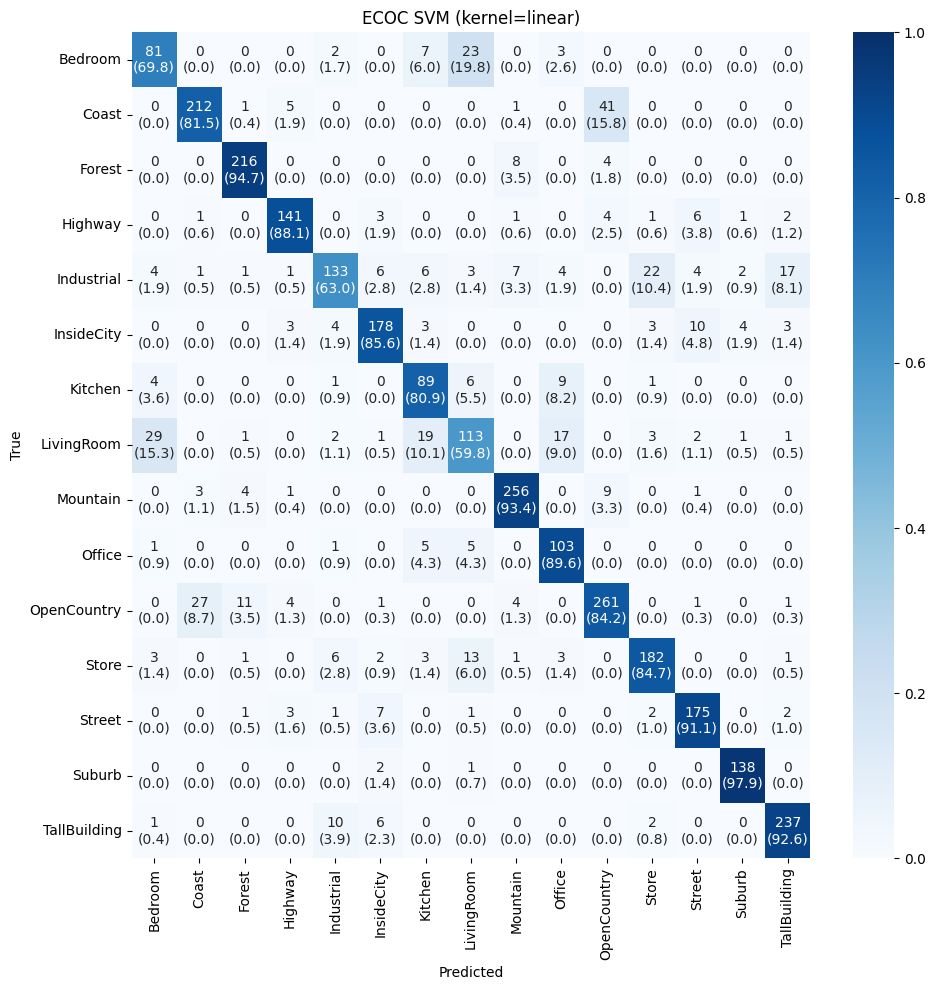



==== Using AlexNet as Feature Extractor + Non-Linear ECOC SVM (rbf) ====

-------------------------------------
Extracting train features...
Extracting validation features...
Extracting test features...
-------------------------------------

Training ECOC-SVM on train set...

ECOC-SVM Test Accuracy: 83.52%



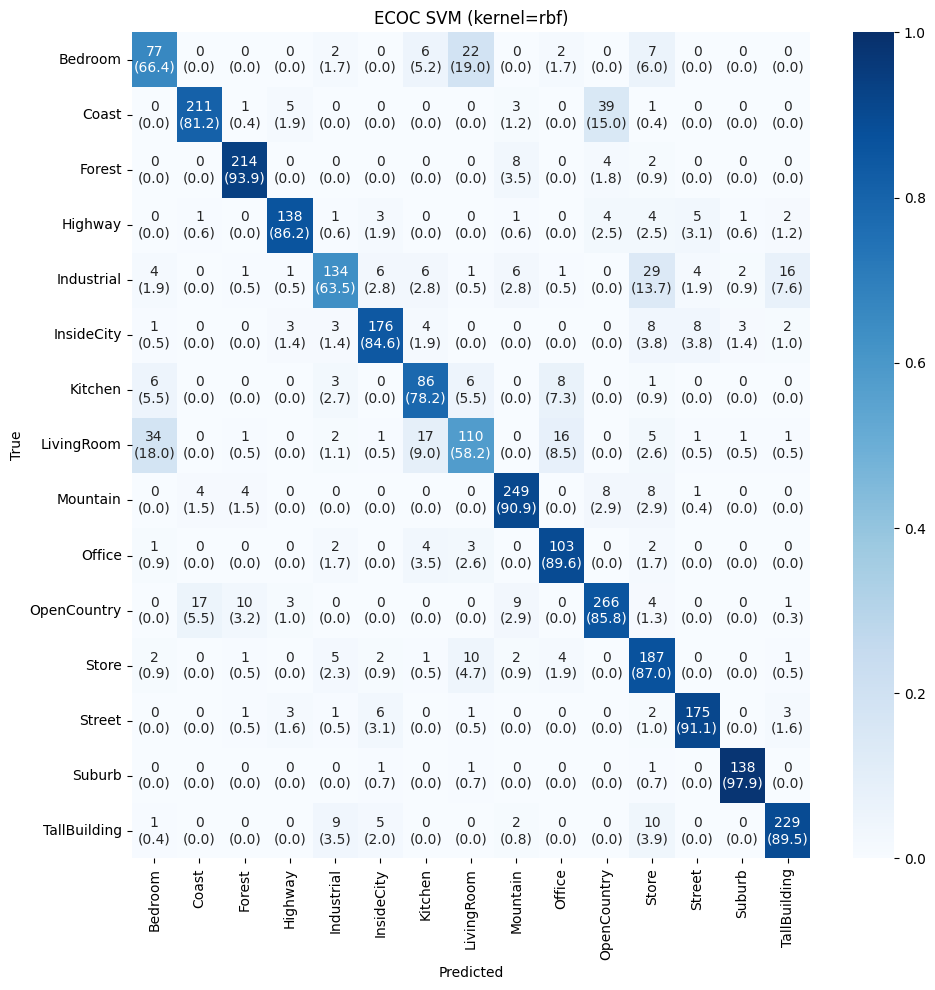



==== Using AlexNet as Feature Extractor + Non-Linear ECOC SVM (poly) ====

-------------------------------------
Extracting train features...
Extracting validation features...
Extracting test features...
-------------------------------------

Training ECOC-SVM on train set...

ECOC-SVM Test Accuracy: 80.84%



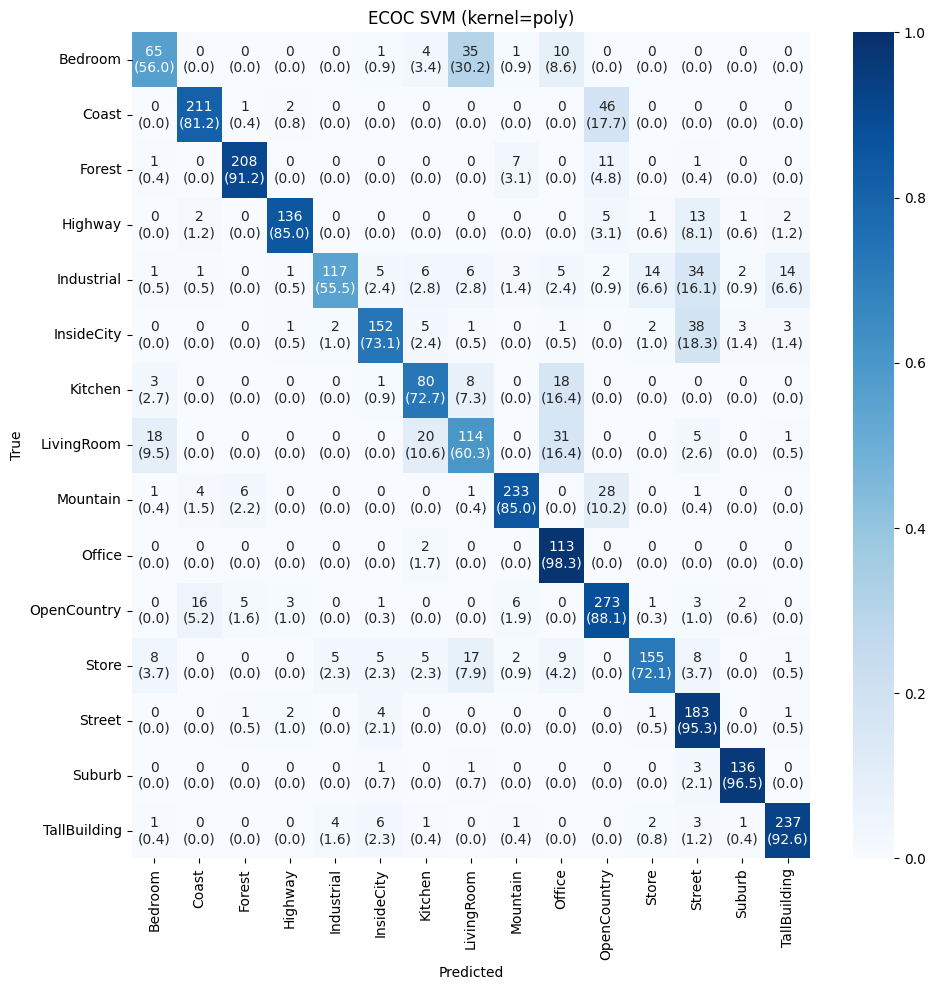



==== Using AlexNet as Feature Extractor + Non-Linear ECOC SVM (sigmoid) ====

-------------------------------------
Extracting train features...
Extracting validation features...
Extracting test features...
-------------------------------------

Training ECOC-SVM on train set...

ECOC-SVM Test Accuracy: 84.29%



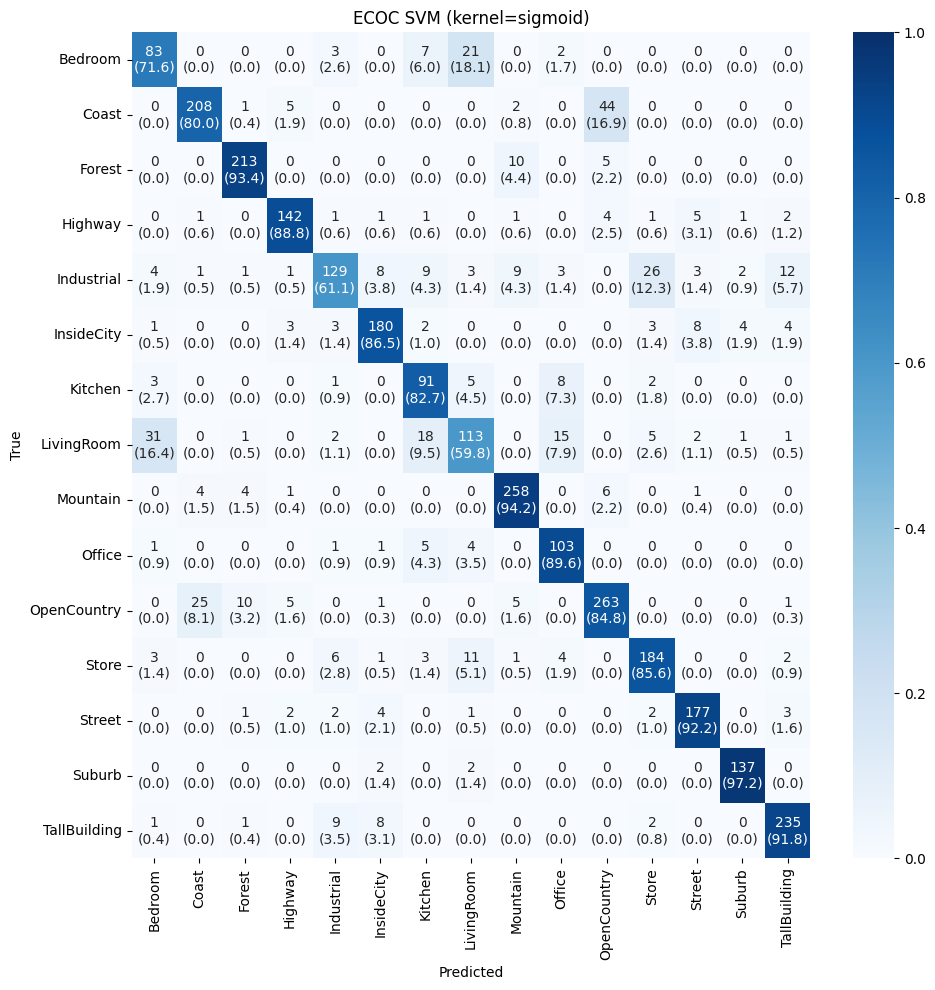

In [ ]:
print("\n==== ECOC SVM ====\n")

print("\n==== Using AlexNet as Feature Extractor + Linear ECOC SVM ====\n")
ecoc_linear_model = train_alexnet_ecoc_svm(
    params=best_params_linear,
    kernel='linear',
    code_size=2
)


print("\n==== Using AlexNet as Feature Extractor + Non-Linear ECOC SVM (rbf) ====\n")
ecoc_rbf_model = train_alexnet_ecoc_svm(
    params=best_params_rbf,
    kernel='rbf',
    code_size=2
)


print("\n==== Using AlexNet as Feature Extractor + Non-Linear ECOC SVM (poly) ====\n")
ecoc_poly_model = train_alexnet_ecoc_svm(
    params=best_params_poly,
    kernel='poly',
    code_size=2
)


print("\n==== Using AlexNet as Feature Extractor + Non-Linear ECOC SVM (sigmoid) ====\n")
ecoc_sigmoid_model = train_alexnet_ecoc_svm(
    params=best_params_sigmoid,
    kernel='sigmoid',
    code_size=2
)
